<a href="https://colab.research.google.com/github/AdamZou/Gradient-EM-Bayesian-Meta-learning/blob/main/_cleaned_ts_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_excel('/content/Sample Dataset.xlsx')

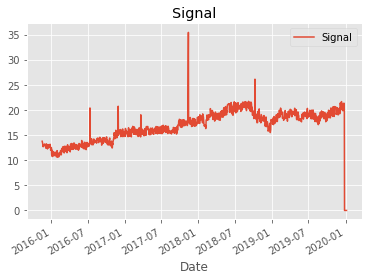

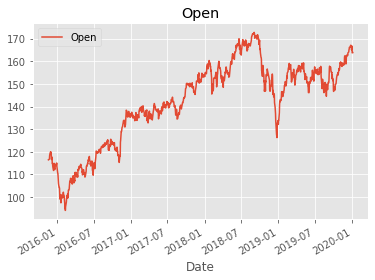

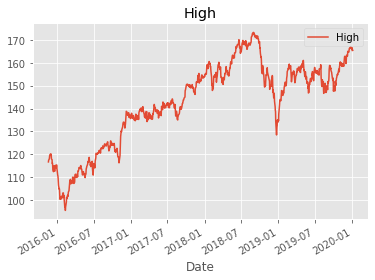

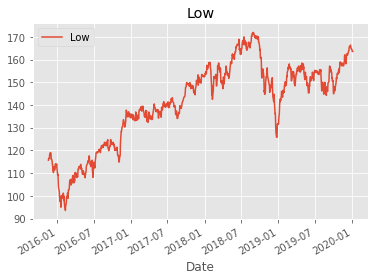

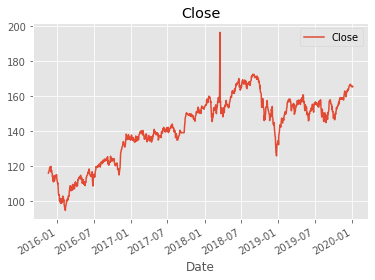

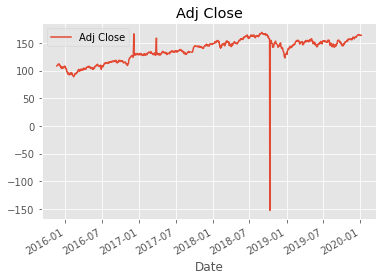

In [82]:
# plot of each column
for x in df.columns[1:]:
  df.plot.line('Date',x,title=x)

In [85]:
# jump detection by differencing with neighboring average
def jump_detect(s,k=5,cutoff=0.1):
    s = df.Signal.rolling(k).mean().shift(-1).dropna()
    ratio = (df.Signal[s.index] -  s ) / s
    r = ratio.abs()
    return r[r >= cutoff]

In [86]:
jump_detect(df['Adj Close'],cutoff=0.2)

161     0.370206
259     0.278842
500     0.690847
731     0.252547
1031    0.219145
1032    1.000000
1033    1.000000
1034    1.000000
Name: Signal, dtype: float64

In [83]:
# missing values in signal
df[df['Signal'] == 0]

,Date,Signal,Open,High,Low,Close,Adj Close
1032,2019-12-27,0.0,167.119995,167.119995,165.429993,165.860001,164.039063
1033,2019-12-30,0.0,165.979996,166.210007,164.570007,165.440002,163.623688
1034,2019-12-31,0.0,165.080002,166.350006,164.710007,165.669998,163.851135
1035,2020-01-02,0.0,166.740005,166.750000,164.229996,165.779999,163.959946
1036,2020-01-03,0.0,163.740005,165.410004,163.699997,165.130005,163.317093
1037,2020-01-06,0.0,163.850006,165.539993,163.539993,165.350006,163.534668


In [84]:
# zero returns 
df[df['Adj Close'].diff() == 0]

,Date,Signal,Open,High,Low,Close,Adj Close
188,2016-08-19,14.374889,122.769997,123.070000,122.279999,122.940002,116.178825
454,2017-09-08,15.518587,138.929993,139.770004,138.619995,139.110001,133.321198
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198
458,2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198
459,2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198
460,2017-09-18,15.518587,142.619995,143.809998,142.600006,139.110001,133.321198
461,2017-09-19,16.798471,143.570007,143.690002,143.089996,139.110001,133.321198
462,2017-09-20,15.953688,143.529999,144.020004,143.259995,139.110001,133.321198


In [95]:
# clean the data by removing jumps and zero returns
df_clean = df[df.Signal>0]  
ab_signal = ['2016-07-13','2016-11-30','2017-03-22','2017-11-13','2018-10-09']
ab_adjclose = ['2016-12-05','2017-03-27','2018-10-10']
df_clean = df_clean[~df_clean['Date'].isin(ab_signal + ab_adjclose)]

In [90]:
# very high correlation between signal and adjusted close price
df_clean['Signal'].corr(df_clean['Adj Close'])

0.9646828699752945

In [91]:
# Correction method b 1: linear regression between signal and adj close, 
# then use the model to predict the missing signal values.

In [98]:
lm = LinearRegression()
X_train = np.array(df_clean['Adj Close']).reshape(-1,1)
y_train = np.array(df_clean['Signal'])
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
df = pd.read_excel('/content/Sample Dataset.xlsx')
X_predict = np.array(df[df.Signal == 0]['Adj Close']).reshape(-1,1)
lm.predict(X_predict)

array([20.60558506, 20.54872089, 20.57985802, 20.59475407, 20.50674852,
       20.53653419])

In [ ]:
# Correction method b 2: use neighboring average to fill the jump values.

In [102]:
 def nb_mean(date,column,k=1):
    ix = df[df['Date'] == date].index[0]
    return (df[column].iloc[ix-k:ix+k+1].sum() - df[column].iloc[ix])/(2*k)

In [ ]:
ab_signal = ['2016-07-13','2016-11-30','2017-03-22','2017-11-13','2018-10-09']
ab_adjclose = ['2016-12-05','2017-03-27','2018-10-10']

In [105]:
for date in ab_signal:
    print(date,nb_mean(date,'Signal'))

2016-07-13 13.7547458724
2016-11-30 15.3182330484
2017-03-22 15.167849913
2017-11-13 17.542351504799992
2018-10-09 20.043604266600003


In [106]:
for date in ab_adjclose:
    print(date,nb_mean(date,'Adj Close'))

2016-12-05 125.79129800000003
2017-03-27 128.95932750000003
2018-10-10 153.075424


In [ ]:
# predition power 1: supervised learning between signal and adj close price returns (lead lag)

In [107]:
# prepare the train/test data
def data2reg(df,k=1,split_ratio=0.8, smooth = -1):
    df['Signal'] = df['Signal'].shift(k)
    if smooth > 0:
        df['Signal'] = df.Signal.rolling(smooth).mean()
    df = df[df.Signal>0]  
    ab_signal = ['2016-07-13','2016-11-30','2017-03-22','2017-11-13','2018-10-09']
    ab_adjclose = ['2016-12-05','2017-03-27','2018-10-10']
    df = df[~df['Date'].isin(ab_signal + ab_adjclose)]

    RE = (df['Adj Close'].diff().dropna() / df['Adj Close']).dropna()
    RE = RE[RE!=0]  # drop 0 return rows
    df['return'] = RE
    df.dropna(inplace=True)
  
    X = np.array(df['Signal']).reshape(-1,1)
    Y = np.array(df['return'])
    
    L_tr = int(Y.shape[0]*split_ratio)
    X_train = X[:L_tr,:]
    X_test = X[L_tr:,:]
    y_train = Y[:L_tr]
    y_test = Y[L_tr:]
    
    return X_train, y_train, X_test, y_test

In [108]:
# regression models, LR and RF
def Regression(DF,k,model,split_ratio=0.8,smooth=-1):
    X_train, y_train, X_test, y_test = data2reg(DF,k,split_ratio,smooth=smooth)
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    switcher = {
        'LR': LinearRegression(),
        'RF': RandomForestRegressor(n_estimators=100,max_depth=2, random_state=0)
    }
    reg = switcher[model].fit(X_train, y_train)

    R2_train = reg.score(X_train, y_train)
   
    print('train mse=', mean_squared_error(y_train, reg.predict(X_train)))
    print('test mse=', mean_squared_error(y_test, reg.predict(X_test) ))

    if model == 'LR':
        print('R2_train=',R2_train)
        print('coef=',reg.coef_) 
        # use statsmodel to get p values
        X0 = np.full(X_train.shape,1)   # null 1's to calculate intercept
        X_tr = np.concatenate((X_train,X0), axis = 1)
        fit = sm.OLS(y_train, X_tr).fit()
        print('p value=',fit.pvalues[0])


In [109]:
for k in range(1,15):
    print('k=',k)
    df = pd.read_excel('/content/Sample Dataset.xlsx')
    Regression(df,k,'LR')

k= 1
train mse= 0.00011311266113396102
test mse= 0.00010203944320607608
R2_train= 0.0004138378570407442
coef= [7.55012887e-05]
p value= 0.563654829010624
k= 2
train mse= 0.00011309989561675443
test mse= 0.00010210471599327596
R2_train= 0.0002956371171911609
coef= [6.33489294e-05]
p value= 0.6255302794019995
k= 3
train mse= 0.00011300542935129952
test mse= 0.00010202853296594498
R2_train= 0.0007462935009252548
coef= [0.00010086]
p value= 0.4380580790519767
k= 4
train mse= 0.00011303612935483756
test mse= 0.0001019994141096805
R2_train= 8.935517079389221e-05
coef= [3.48273649e-05]
p value= 0.7884771127490251
k= 5
train mse= 0.0001130331934497623
test mse= 0.00010207870266365376
R2_train= 4.499738839380817e-05
coef= [2.47083676e-05]
p value= 0.8490079228483011
k= 6
train mse= 0.00011305444001136765
test mse= 0.00010192257089450503
R2_train= 1.446566286456008e-05
coef= [1.40163609e-05]
p value= 0.9140391189231722
k= 7
train mse= 0.00011298106274082818
test mse= 0.00010196404818572711
R2_tr

In [110]:
for k in range(1,15):
    print('k=',k)
    df = pd.read_excel('/content/Sample Dataset.xlsx')
    Regression(df,k,'RF')

k= 1
train mse= 0.00010943764866427003
test mse= 0.00010291093082874201
k= 2
train mse= 0.0001074107258321139
test mse= 0.00010224831173732688
k= 3
train mse= 0.0001092970968771034
test mse= 0.00010246712618609359
k= 4
train mse= 0.00010947827445965305
test mse= 0.00010187445601807655
k= 5
train mse= 0.00010982535966009304
test mse= 0.00010212023389563865
k= 6
train mse= 0.00010946512979829488
test mse= 0.00010254319290275673
k= 7
train mse= 0.00010916341599146919
test mse= 0.0001019553613453703
k= 8
train mse= 0.00010941117107188124
test mse= 0.00010143338308760659
k= 9
train mse= 0.00010935726849473268
test mse= 0.00010239170225145557
k= 10
train mse= 0.00010885584773455906
test mse= 0.00010315909433127033
k= 11
train mse= 0.00010881687015735003
test mse= 0.0001021590136341719
k= 12
train mse= 0.00010842997732258177
test mse= 0.00010238858556455107
k= 13
train mse= 0.00010879617455111748
test mse= 0.00010254124443826159
k= 14
train mse= 0.00010901346024292142
test mse= 0.000102883486

In [111]:
# LR with smoothed signal
for k in range(1,15):
    print('k=',k)
    df = pd.read_excel('/content/Sample Dataset.xlsx')
    Regression(df,k,'LR',smooth=5)

k= 1
train mse= 0.00011300000414322889
test mse= 0.00010197784068547008
R2_train= 0.0003386086019534496
coef= [7.08534203e-05]
p value= 0.6014626792653556
k= 2
train mse= 0.00011303294973654799
test mse= 0.00010186429126013482
R2_train= 0.0002045507576776684
coef= [5.50300625e-05]
p value= 0.6847909955757325
k= 3
train mse= 0.00011314660634056172
test mse= 0.00010192612272660156
R2_train= 8.6083059509523e-06
coef= [1.12943907e-05]
p value= 0.9336773512211357
k= 4
train mse= 0.00011311356056008407
test mse= 0.00010198055276988136
R2_train= 0.0001641238307623638
coef= [-4.93315279e-05]
p value= 0.7164862278690136
k= 5
train mse= 0.00011281040987069388
test mse= 0.00010201797948800814
R2_train= 0.0007244100966343757
coef= [-0.00010353]
p value= 0.4457054489105522
k= 6
train mse= 0.00011279304475243758
test mse= 0.00010203125660297463
R2_train= 0.0010925008176646545
coef= [-0.00012719]
p value= 0.349267056460722
k= 7
train mse= 0.00011239347119775792
test mse= 0.00010244302014423007
R2_tra

In [112]:
# RF with smoothed signal
for k in range(1,15):
    print('k=',k)
    df = pd.read_excel('/content/Sample Dataset.xlsx')
    Regression(df,k,'RF',0.8,smooth = 5)


k= 1
train mse= 0.00011005904711415779
test mse= 0.00010188288773623073
k= 2
train mse= 0.00010930957279811443
test mse= 0.00010196400153181295
k= 3
train mse= 0.00011072834966484603
test mse= 0.00010195068403485602
k= 4
train mse= 0.00011001017260974087
test mse= 0.00010222239649404284
k= 5
train mse= 0.00011006972403040874
test mse= 0.0001021624194003482
k= 6
train mse= 0.00010995934147473297
test mse= 0.00010159542776391964
k= 7
train mse= 0.00010906490221394378
test mse= 0.00010261396269745886
k= 8
train mse= 0.0001090483891546817
test mse= 0.00010361236291267369
k= 9
train mse= 0.0001092898143805779
test mse= 0.00010369252335929755
k= 10
train mse= 0.00010913551203965782
test mse= 0.00010239548059398477
k= 11
train mse= 0.00010878213335694009
test mse= 0.00010222973439851805
k= 12
train mse= 0.00010769150567269021
test mse= 0.00010310760214557964
k= 13
train mse= 0.00010795155521619593
test mse= 0.00010242456892981566
k= 14
train mse= 0.00010780174989953873
test mse= 0.00010306701

In [ ]:
pd.DataFrame(abs(y_train)).describe()

,0
count,808.000000
mean,0.007828
std,0.007216
min,0.000059
25%,0.002780
50%,0.005813
75%,0.010665
max,0.053721


In [113]:
# # predition power 2: multivariant time series prediciton with/without the signal

In [8]:
# prepare the data
def TS_data(df, smooth = -1,signal=False):
    
    if smooth > 0:
        df['Signal'] = df.Signal.rolling(smooth).mean()
    df = df[df.Signal>0]  
    ab_signal = ['2016-07-13','2016-11-30','2017-03-22','2017-11-13','2018-10-09']
    ab_adjclose = ['2016-12-05','2017-03-27','2018-10-10']
    df = df[~df['Date'].isin(ab_signal + ab_adjclose)]

    if not signal:
        df_return = df.drop(['Date','Signal'], axis=1).diff() / df.drop(['Date','Signal'], axis=1)
    else:
        df_return = df.drop(['Date'], axis=1).diff() / df.drop(['Date'], axis=1)
    
    df_return = df_return[df_return['Adj Close']!=0]

    df_return.dropna(inplace=True)
    '''
    X = np.array(df['Signal'])
    Y = np.array(df['return'])
    L_tr = int(Y.shape[0]*split_ratio)
    X_train = X[:L_tr,:]
    X_test = X[L_tr:,:]
    y_train = Y[:L_tr]
    y_test = Y[L_tr:]
    '''
    return df_return
    
# data without signal
df = pd.read_excel('/content/Sample Dataset.xlsx')
df_return = TS_data(df)
# data with signal
df = pd.read_excel('/content/Sample Dataset.xlsx')
df_return_signal = TS_data(df,signal=True)

In [ ]:
# ARIMA by statsmodels

In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
re = df_return['Adj Close']

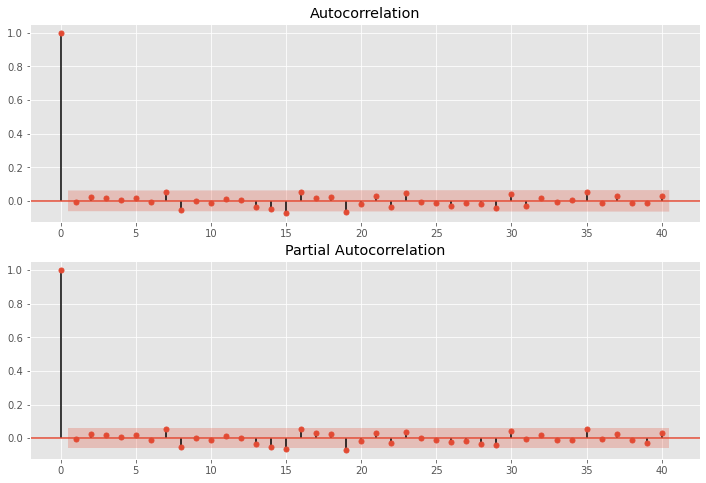

In [114]:
# acf, pacf plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(re,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(re,lags=40,ax=ax2)

In [ ]:
model=ARIMA(re,order=(1,1,1))
model_fit=model.fit(trend='c')
model_fit.summary()

In [29]:
print(r2_score(re[1:], model_fit.fittedvalues))
print(mean_squared_error(re[1:],model_fit.fittedvalues))

-0.9937620035555872
0.00022139219165674847


In [ ]:
model=ARIMA(re,order=(2,0,0))
model_fit=model.fit(trend='c')
model_fit.summary()

In [33]:
print(r2_score(re, model_fit.fittedvalues))
print(mean_squared_error(re,model_fit.fittedvalues))

0.0005758674002825925
0.00011090498467462612


In [ ]:
# VAR

In [34]:
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error

In [39]:
def var_run(data):
    #data = data_var
    train = data[:int(0.8*(len(data)))]
    valid = data[int(0.8*(len(data))):]
    model = VAR(endog=train)
    model_fit = model.fit()
    train_r2 = r2_score(train['Adj Close'][1:],model_fit.fittedvalues['Adj Close'])
    train_mse = mean_squared_error(train['Adj Close'][1:], model_fit.fittedvalues['Adj Close'], squared=True)
    # out-of-sample prediction
    prediction = []
    for i in range(len(valid)):    
        prediction.append(model_fit.forecast(np.array(data[:len(train)+i]), steps=1)[0])
    prediction = np.array(prediction)
    
    #test_r2 = r2_score(valid['Adj Close'],prediction[:,-1])
    test_mse = mean_squared_error(valid['Adj Close'],prediction[:,-1], squared=True)

    print('train_r2 =', train_r2)
    #print('test_r2 =', test_r2)
    print('train mse = ', train_mse)
    print('test mse = ', test_mse)


In [40]:
# 
var_run(df_return)

train_r2 = 0.011417153558460846
train mse =  0.00011165866952132995
test mse =  0.00010716895152619292


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [41]:
var_run(df_return_signal)

train_r2 = 0.014805354348180089
train mse =  0.00011127597828446196
test mse =  0.00010744835739002836


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# deep models, lstm

In [43]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [75]:
def lstm(data,signal = False):
    reframed = series_to_supervised(data,1,1)
    # drop columns we don't want to predict
    if not signal:
        reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)
    else:
        reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)

    values = reframed.values
    n_train = int(0.8*len(values))
    train = values[:n_train]
    test = values[n_train:]
    trainX,trainY = train[:,:-1],train[:,-1]
    testX,testY = test[:,:-1],test[:,-1]
    trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
    testX = testX.reshape(testX.shape[0],1,testX.shape[1])
    stop_noimprovement = EarlyStopping(patience=10)
    model = Sequential()
    model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
    model.add(Dense(1))
    model.compile(loss="mse",optimizer="adam")
    history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=500,verbose=2,shuffle=False)

    return model,history

   

In [ ]:
# without signal
model, history = lstm(df_return)

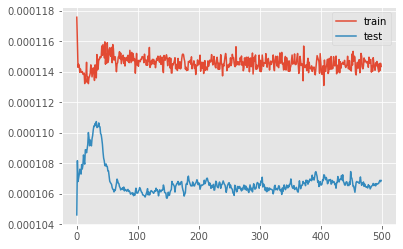

In [77]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [ ]:
# with signal
model, history = lstm(df_return_signal, signal=True)

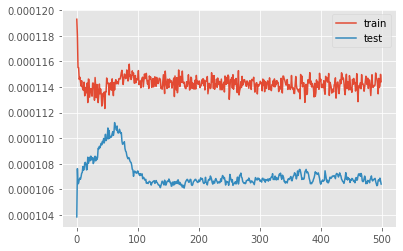

In [79]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()